In [ ]:
import keras
import tensorflow as tf
from keras.layers import Input
import numpy as np
from keras import layers, Input
from keras.models import Model
import pickle
from keras.utils import to_categorical
#import matplotlib.pyplot as plt
from keras.losses import mean_squared_error, CategoricalCrossentropy
import sys
from keras.datasets import mnist, cifar10, cifar100
from sklearn.model_selection import train_test_split
import math
from keras import backend as K
from keras.layers import Layer
from numpy.random import seed
import random

import pickle
import random
#from google.colab import drive

In [ ]:
seed(1)
tf.random.set_seed(1)

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
#(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
#(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()
unique, counts = np.unique(train_labels, return_counts=True)
input_data_shape = np.array(train_images)[0].shape
if len(input_data_shape) == 2: input_data_shape = (input_data_shape[0], input_data_shape[1], 1)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
def prepare_data(data, num_clients, alpha, x):
  inputs, labels = data[0], data[1]
  indixes = np.arange(labels.shape[0])
  np.random.shuffle(indixes)
  inputs = inputs[indixes]
  labels = labels[indixes]
  Dirichlet_samples = np.random.dirichlet(tuple(np.ones(len(unique))*alpha), num_clients)
  nspec = np.array([(Dirichlet_samples[c,:]*x).astype(int) for c in range(num_clients)]) #num_samples_per_each_class
  I = []
  O = []
  for c in range(num_clients):
    Xs = []
    Ys = []
    for i in unique:
      inds = np.random.choice( np.where(labels == i)[0], size=nspec[c,i], replace=False)
      if len(inds)!=0:
        Xs.extend( inputs[inds] )
        Ys.extend( [i]*len(inds) )
    Xs = np.array(Xs).reshape((np.array(Xs).shape[0], input_data_shape[0], input_data_shape[1], input_data_shape[2]))
    Xs = Xs.astype('float32') / 255
    Ys = to_categorical(np.array(Ys), len(unique))
    I.append(Xs)
    O.append(Ys)
  global_test_input = test_images.reshape((np.array( test_images).shape[0],  input_data_shape[0], input_data_shape[1], input_data_shape[2])).astype('float32') / 255
  global_test_output = to_categorical(np.array(test_labels), len(unique))
  global_test_data = (global_test_input[:1000], global_test_output[:1000])
  public_data = (global_test_input[1000:1000+x], global_test_output[1000:1000+x])
  return (I,O), global_test_data, public_data


In [ ]:
class NN(Model):
  def __init__(self):
    super(NN, self).__init__()
    self.conv1 = layers.Conv2D(32, (3, 3), activation='relu')
    self.conv2 = layers.Conv2D(64, (3, 3), activation='relu')
    self.maxpool = layers.MaxPooling2D((2, 2))
    self.flatten = layers.Flatten()
    self.dense1 = layers.Dense(64, activation='relu')
    self.dense2 = layers.Dense(32, activation='relu')
    self.dense3 = layers.Dense(10, activation='softmax')

    self.LN = np.array( [layer.name for layer in self.layers] )

  def __call__(self, input):
    y = self.conv1(input)
    y = self.maxpool(y)
    y = self.conv2(y)
    y = self.maxpool(y)
    y = self.flatten(y)
    y = self.dense1(y)
    v = self.dense2(y)
    p = self.dense3(v)
    return p

  ###########################################
  def intermidiate_output(self, input, layer_name):
    int_out = input
    i = 0
    while True:
      int_out = self.layers[i](int_out)
      if self.layers[i].name == layer_name: break
      i += 1
    return int_out

  #################################
  def freeze(self, layer_name):
    i = -1
    while True:
      if self.layers[i].name == layer_name:  break
      self.layers[i].trainable = False
      i -= 1
  def unfreeze(model):
    model.trainable = True



class NN2(Model):
  def __init__(self):
    super(NN2, self).__init__()
    self.conv1 = layers.Conv2D(16, (3, 3), activation='relu')
    self.BN1 = layers.BatchNormalization()
    self.conv2 = layers.Conv2D(16, (3, 3), activation='relu')
    self.BN2 = layers.BatchNormalization()
    self.maxpool1 = layers.MaxPooling2D((2, 2))
    self.dropout1 = layers.Dropout(0.25)
    self.conv3 = layers.Conv2D(32, (3, 3), activation='relu')
    self.BN3 = layers.BatchNormalization()
    self.conv4 = layers.Conv2D(32, (3, 3), activation='relu')
    self.BN4 = layers.BatchNormalization()
    self.maxpool2 = layers.MaxPooling2D((2, 2))
    self.dropout2 = layers.Dropout(0.25)
    self.flatten = layers.Flatten()
    self.dense1 = layers.Dense(128, activation='relu')
    self.dropout3 = layers.Dropout(0.5)
    self.dense2 = layers.Dense(10, activation='softmax')

  def __call__(self, input):
    y = self.conv1(input)
    y = self.BN1(y)
    y = self.conv2(y)
    y = self.BN2(y)
    y = self.maxpool1(y)
    y = self.dropout1(y)

    y = self.conv3(y)
    y = self.BN3(y)
    y = self.conv4(y)
    y = self.BN4(y)
    y = self.maxpool2(y)
    y = self.dropout2(y)

    y = self.flatten(y)
    y = self.dense1(y)
    y = self.dropout3(y)
    p = self.dense2(y)
    return p
####################################### SERVER
class Server():
  def __init__(self, clients):
    self.clients = clients
    self.Agg_Weights()
  def Agg_Weights(self):
    self.agg_weight = []
    for client in self.clients:
      Predict(client.model, client.data)
      self.agg_weight.append(  (np.sum([np.prod(keras.backend.get_value(w).shape) for w in client.model.trainable_weights]))  )

  ### Aggregate all clients' local knowledge for each specific client (just soft labels)
  def Aggregate(self, vectors):
    vectors = np.array(vectors)
    vectors = np.average(vectors, weights=self.agg_weight ,axis=0)
    return vectors




##############################################
######### BIAS #############################
##############################################
  def EKF_Agg_bias(self, localPredictions, groundTruth, num_class, num_clients, TopN, BETA, round, num_round, final_beta):
      self.localPredictions = localPredictions
      self.groundTruth = groundTruth
      self.num_class = num_class
      self.num_clients = num_clients
      self.TopN = TopN
      self.BETA = BETA
      self.round = round
      self.num_round = num_round
      self.final_beta = final_beta

      true_labels = np.argmax(groundTruth, axis=1)
      ClassBiasDistributions = []

      ## calculate class confidence distribution for each client
      for client in range(len(localPredictions)):
          local_softLabels = localPredictions[client]
          bias_distribution =  np.mean(local_softLabels, axis=0)
          ClassBiasDistributions.append(bias_distribution)

      aggregated_knowledege = []
      ## determine near (neighbor) clients for each specific client based on the most similar class confidence distribution
      for client in range(len(localPredictions)):
          dists = []
          for neighbor in range(len(localPredictions)):
              d = np.linalg.norm(ClassBiasDistributions[client] - ClassBiasDistributions[neighbor])
              dists.append(d)


          TopN = min(num_clients,TopN)
          sorting_index = np.argsort(dists)[:TopN]
          dists.sort()
          dists = dists[:TopN]
          selected_localPredictions = [localPredictions[index][:][:] for index in sorting_index]
          selected_localPredictions = np.array(selected_localPredictions)

          ### calculate the weights of aggregation
          aggWeights = 1.0/np.array(dists)**2

          ### balance between the local and neighbor's knowledge (local knowledge is BETA times more important than the nearest neighbor's knowledege)
          BETA = BETA + ((round+1)/num_round) * (final_beta - BETA)
          #BETA = BETA*np.exp((round/num_round)*np.log(final_beta/BETA))
          aggWeights[0] = BETA*aggWeights[1]
          aggWeights = aggWeights/np.sum(aggWeights)

          ### personalized aggregated knowledge
          personalized_aggregated_knowledege = np.average(selected_localPredictions, weights=aggWeights, axis=0)
          aggregated_knowledege.append(personalized_aggregated_knowledege)

      return aggregated_knowledege



################################################################################






  #################
  def soft2hard(self, Ps):
    hards = []
    for p in Ps:
      a=np.zeros(len(p))
      a[np.argmax(p)] = 1
      hards.append(a)
    return np.array(hards)


############################################# DEVICE
class Device():
  def __init__(self, id, data, TEST_PERCENT, initial_model):
    self.id = id
    self.initial_model = initial_model
    x, xt, y, yt = train_test_split(data[0], data[1], test_size=int(TEST_PERCENT*data[0].shape[0]/100), random_state=42)
    self.data = (x, y)
    self.test_data = (xt, yt)
    self.Acc = []
    self.Loss = []
    self.global_test_Acc = []
    self.local_test_Acc = []
    self.local_test_loss = []

    initial_model_weights = self.initial_model.get_weights()
    self.model = NN()
    self.model.set_weights(initial_model_weights)



################################# Functions
def soft2hard(Ps):
    hards = []
    for p in Ps:
      a=np.zeros(len(p))
      a[np.argmax(p)] = 1
      hards.append(a)
    return np.array(hards)

def Train(model, data):
    dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(BATCH_SIZE)
    epoch_loss = []
    for epoch in range(EPOCHS):
      batch_loss = []
      for batch in dataset:
        with tf.GradientTape() as tape:
          preds = model(batch[0])
          error = keras.losses.CategoricalCrossentropy(from_logits=False)(batch[1], preds)
        gradients = tape.gradient(error, model.trainable_weights)
        tf.keras.optimizers.legacy.Adam().apply_gradients(zip(gradients, model.trainable_weights))
        batch_loss.append(float(error))
      epoch_loss.append(np.mean(batch_loss))
    return np.mean(epoch_loss)

def Predict(model, data):
    y = model(data[0])
    return np.array(y)

def Evaluate(model, data):
    outputs = soft2hard(np.array(model(data[0])))
    counter = 0
    for i in range(len(outputs)):
      if np.where(data[1][i]==1)[0][0] == np.where(outputs[i]==1)[0][0]:
        counter += 1
    acc = (counter/ data[0].shape[0])*100
    return acc


def Distill(model, data, temperature=1):
    dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(BATCH_SIZE)
    epoch_loss = []
    for epoch in range(EPOCHS):
      batch_loss = []
      for batch in dataset:
        with tf.GradientTape() as tape:
          preds = model(batch[0])
          error1 = keras.losses.CategoricalCrossentropy(from_logits=False)(batch[1], preds)
          error2 = keras.losses.KLDivergence()(batch[2], preds)
          error = error1 + (temperature**2)*error2
        gradients = tape.gradient(error, model.trainable_weights)
        tf.keras.optimizers.legacy.Adam().apply_gradients(zip(gradients, model.trainable_weights))
        batch_loss.append(float(error))
      epoch_loss.append(np.mean(batch_loss))
    return np.mean(epoch_loss)



In [ ]:
EPOCHS = 1
BATCH_SIZE = 8
NUM_CLIENTS = 20
NUM_ROUNDS = 50
NUM_CLASS = 10
ALPHA_Dirichlet = 1
NUM_DATA_PER_CLIENT = 50
TEST_PERCENT = 20


BETA = 10 # a parameter to strike a balance between local knowledge and global knowledge in personalized aggregation
final_beta = 10
TopN = NUM_CLIENTS # the number of neighbors for each client for personalized aggregation

### initial model for all clients
InitialModel = NN()

Niid_data, global_test_data, public_data   = prepare_data((train_images, train_labels), NUM_CLIENTS, ALPHA_Dirichlet,  NUM_DATA_PER_CLIENT)
clients = [Device(id, (Niid_data[0][id], Niid_data[1][id]), TEST_PERCENT, InitialModel) for id in range(NUM_CLIENTS)]
server = Server(clients)


ROUND: 0
24.513888888888886
ROUND: 1
33.12499999999999
ROUND: 2
36.458333333333336
ROUND: 3
35.902777777777786
ROUND: 4
49.236111111111114
ROUND: 5
50.347222222222214
ROUND: 6
48.68055555555556
ROUND: 7
59.23611111111112
ROUND: 8
58.124999999999986
ROUND: 9
58.125
ROUND: 10
63.19444444444446
ROUND: 11
67.08333333333334
ROUND: 12
67.70833333333334
ROUND: 13
72.1527777777778
ROUND: 14
69.37500000000001
ROUND: 15
72.15277777777779
ROUND: 16
76.11111111111113
ROUND: 17
70.55555555555557
ROUND: 18
72.1527777777778
ROUND: 19
71.59722222222223
ROUND: 20
72.15277777777779
ROUND: 21
79.44444444444446
ROUND: 22
78.26388888888891
ROUND: 23
77.7777777777778
ROUND: 24
81.04166666666667
ROUND: 25
70.97222222222224
ROUND: 26
77.70833333333334
ROUND: 27
77.15277777777779
ROUND: 28
79.44444444444446
ROUND: 29
74.44444444444447
ROUND: 30
74.93055555555557
ROUND: 31
75.0
ROUND: 32
79.30555555555557
ROUND: 33
77.22222222222224
ROUND: 34
79.30555555555557
ROUND: 35
76.59722222222224
ROUND: 36
77.1527777777

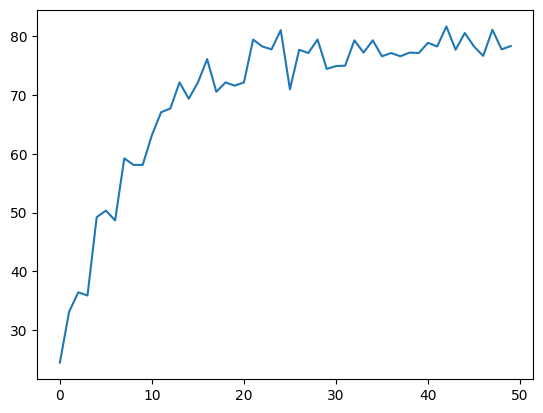

In [ ]:
for round in range(NUM_ROUNDS):

  print('ROUND: {}'.format(round))
  softlabels = []

  for client in clients:
    ## Local training
    Train(client.model, client.data)

    ## Local Knowledge Extraction
    softlabel = Predict(client.model, public_data)
    softlabels.append(softlabel)


  ##### Knowledge Aggregation (server side)
  ### FedMD
  #Agg_softlabels = server.Aggregate(softlabels)

  ### KnFu
  Agg_softlabels = server.EKF_Agg_bias(softlabels, public_data[1], NUM_CLASS, NUM_CLIENTS, TopN, BETA, round, NUM_ROUNDS, final_beta)

  ##### Fine-tuning
  for client in clients:
    ## Local fine-tuning via knowledge distillation

    ### FedMD
    #loss = Distill(client.model, (public_data[0], public_data[1],  Agg_softlabels))

    ### Only local training
    #loss = Train(client.model, client.data)

    ### KnFu
    loss = Distill(client.model, (public_data[0], public_data[1],  Agg_softlabels[client.id]))


    acc = Evaluate(client.model, client.test_data)
    client.Acc.append(acc)

  print(np.mean( [client.Acc for client in clients], axis=0 )[-1])


ALTA = np.mean( [client.Acc for client in clients], axis=0 ) # ALTA: averag local test accuracy across all clients
#plt.figure()
#plt.plot(range(NUM_ROUNDS), ALTA)

